Ajay Prakash Nair's  
Fellowship.ai image segmentation challenge  
The project will apply a pre-trained segmentation model to the _CelebA_ dataset.

In [ ]:
import numpy as np 
import pandas as pd 
import os 
import matplotlib.pyplot as plt
from matplotlib import gridspec
import seaborn as sns 
import cv2
from shutil import move
import tensorflow as tf
import tarfile
import tempfile
from six.moves import urllib
from PIL import Image

In [1]:
pathbase=r"C:\Users\ajay\fellowshipAI" 
attr_path=r"images\annotations\list_attr_celeba.txt"
celeb_attr=pd.read_csv(os.sep.join([pathbase, attr_path]), sep=" +", header=1, engine='python')
attr_tidy=celeb_attr.melt(var_name='attribute')

NameError: ignored

To verify there are no null values

In [ ]:
print(celeb_attr.info())


<class 'pandas.core.frame.DataFrame'>
Index: 202599 entries, 000001.jpg to 202599.jpg
Data columns (total 40 columns):
5_o_Clock_Shadow       202599 non-null int64
Arched_Eyebrows        202599 non-null int64
Attractive             202599 non-null int64
Bags_Under_Eyes        202599 non-null int64
Bald                   202599 non-null int64
Bangs                  202599 non-null int64
Big_Lips               202599 non-null int64
Big_Nose               202599 non-null int64
Black_Hair             202599 non-null int64
Blond_Hair             202599 non-null int64
Blurry                 202599 non-null int64
Brown_Hair             202599 non-null int64
Bushy_Eyebrows         202599 non-null int64
Chubby                 202599 non-null int64
Double_Chin            202599 non-null int64
Eyeglasses             202599 non-null int64
Goatee                 202599 non-null int64
Gray_Hair              202599 non-null int64
Heavy_Makeup           202599 non-null int64
High_Cheekbones        202

Boxplots to visualize relative proportion of images that have each attribute

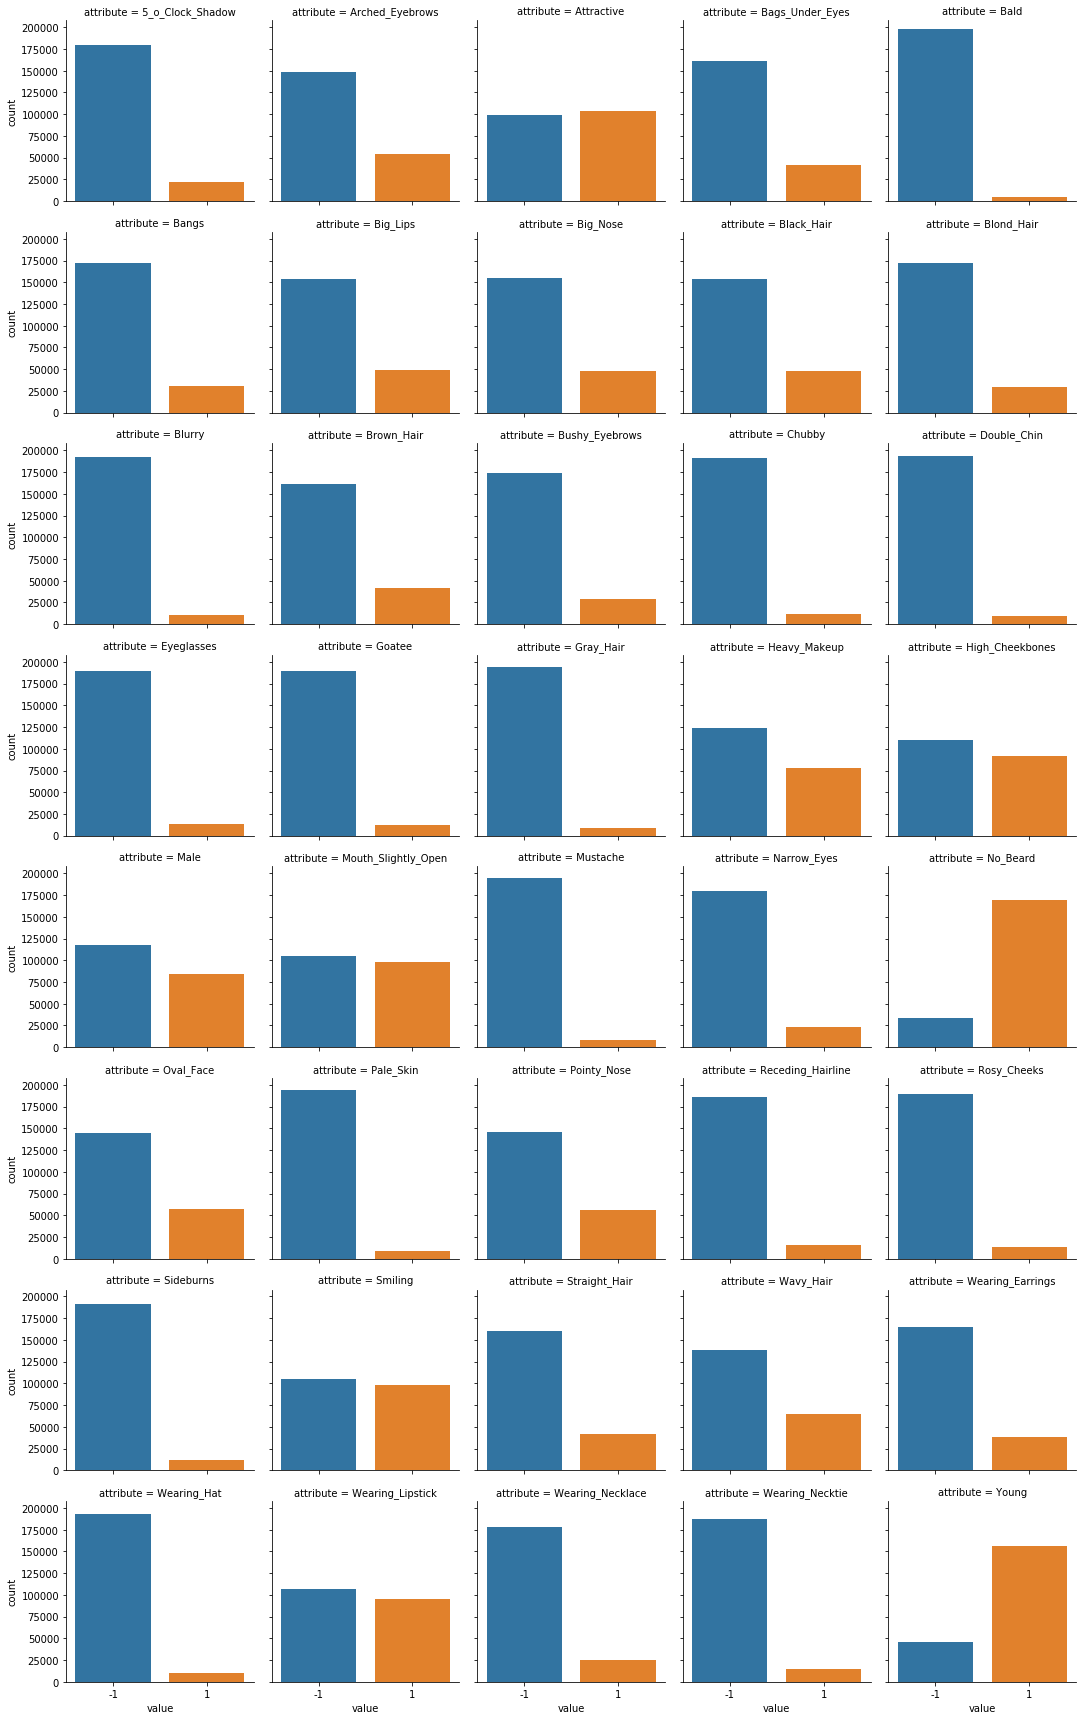

In [ ]:

sns.catplot(data=attr_tidy, x='value', y=None, col='attribute', kind='count', col_wrap=5, height=3, aspect=1)

We can see that a number of attributes are not going to be well represented in this set. Looking at a combination of proportional representation and how that attribute would effect an object's boundary, we can identify a few attributes that may perform poorly: wearing_hat, eyeglasses, mustache and blurry. Though the model won't be trained on this dataset, we will still test these potential edge cases on the model we ultimately use. 

The next step is to verify what the bounding boxes supplied with the celebA dataset look like on the wild images. It's unlikely that the bounding boxes will be useful to me, but if they closely match facial regions they could be used for fine tuning a pre-trained model.

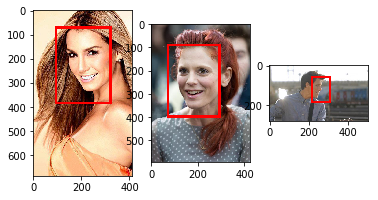

In [ ]:
bound_path=r"images\annotations\list_bbox_celeba.txt"
bboxes=pd.read_csv(os.sep.join([pathbase, bound_path]), sep=" +", header=1, nrows=3, engine='python')

#Drawing 1st 3 images as examples
bound_check_img=['000001.jpg', '000002.jpg', '000003.jpg']
img_wild_base_path = r"images\wild\img_celeba"
f = plt.figure() #generate plot figure 
for i in range(3): 
    bound_temp = bboxes.iloc[i,1:5]
    x1, x2 = bound_temp[0], bound_temp[0] + bound_temp[2]
    y1, y2 = bound_temp[1], bound_temp[1] + bound_temp[3]
    img_path = os.sep.join([pathbase, img_wild_base_path, bound_check_img[i]])
    image = cv2.imread(img_path)
    image = cv2.rectangle(image, (x1, y1), (x2, y2), (0,0,255), 10)
    f.add_subplot(1,3,i+1)
    image = image[:, :, ::-1] #Without converting between RGB/BGR, cv2 will display with strong blue hue
    plt.imshow(image)
plt.show()

The next step will be splitting our dataset into training/validation datasets as if we were going to use them to train the model. 

In [ ]:
#CelebA dataset includes a training/validation/testing split in the form of a text file with train/eval/test labels. 
partition_path = r"images\annotations\list_eval_partition.txt"
eval_part = pd.read_csv(os.sep.join([pathbase, partition_path]), sep=" ", header=None ).rename(columns={0:'image', 1:'group'})

#setting paths for original, training, validation and test groupings to shorten code for moving files into their correct folders
image_bp = os.sep.join([pathbase,r"images\wild"]) #image basepath
orig_img_path = os.sep.join([image_bp,'img_celeba']) #original image folder, will be copied to split folders for test/train/val
train_img_path = os.sep.join([image_bp, 'training']) #training images folder
valid_img_path = os.sep.join([image_bp, 'validation']) #validation images folder
test_img_path = os.sep.join([image_bp, 'test']) #test images folder

#only want to run if partitions not already created with all images. Verify 
split_sum_len = len([name for name in os.listdir(train_img_path)]) + len([name for name in os.listdir(valid_img_path)]) + len([name for name in os.listdir(test_img_path)])
if split_sum_len < len(eval_part): 
   for i in range(len(eval_part)):
    #partitioning done through 2nd column. 0=train, 1=eval, 2=test

    if eval_part.iloc[i,1] == 0:
        move(os.sep.join([orig_img_path,eval_part.iloc[i,0]]), os.sep.join([train_img_path, eval_part.iloc[i,0]]))
    elif eval_part.iloc[i,1] == 1:
        move(os.sep.join([orig_img_path,eval_part.iloc[i,0]]), os.sep.join([valid_img_path, eval_part.iloc[i,0]]))
    else:
        move(os.sep.join([orig_img_path,eval_part.iloc[i,0]]), os.sep.join([test_img_path, eval_part.iloc[i,0]]))

With some basic EDA done and everything set up on our local environment, it's time to choose a model. There are two important factors in the choice for this particular problem: varying input sizes and the nature of the problem giving relative pixel location a high level of importance. Using a FCN would help with both issues. Resizing and padding could be used to get all images to a standard size, but that would lose some of the finer details at boundaries in the images. In particular, older segmentation models seem to struggle with small-pixel features such as single strands of hair. This architecture has output match input image size, though I would pair this with a batch generator to run same-size images concurrently. It would likely be worth doing some small resize+padding operations there to increase batch size. The second reason I chose FCN-8 was that human portraits are generally posed in very similar states. Relative locations within the image are important. For example, pixels that are above hair but do not match hair characteristics are likely background. The lack of dense layers and the addition of skips from early pooling steps help to preserve spatial information.

Although I will be utilizing a pre-trained model, I will create a representative FCN-8 architexture. The FCN-16 and FCN-32 architectures would work with less accuracy due to the large stride needed when upsampling directly from the last pool layer. In general, both FCN-16 and FCN-32 will generate too coarse of a map.

FCN-8 can be made using the first layers of a pre-trained VGG-16 model. We should see higher initial skill and a faster skill improvement using pre-trained weights from a VGG-16 model as the encoder. The models will have to diverge once the VGG-16 architecture gets to the fully connected layers. The pre-trained weights from the original VGG-16 model can still be used though, and should be extracted. 

In [2]:
#Model creation will start by taking layers from VGG-16
def load_vgg_16(vgg_model_path):
    model = tf.saved_model.loader.load(['VGG16'], vgg_model_path)
    
    graph = tf.get_default_graph()
    image_in = graph.get_tensor_by_name('image_input:0')
    keep_per = graph.get_tensor_by_name('keep_prob:0')
    
    #3,4,7 are specifically needed as they are used to create skip-layers used in the upsampling process
    #L_7 is the last stage before this model deviates from VGG-16 architecture
    L_3 = graph.get_tensor_by_name('layer3_out:0')
    L_4 = graph.get_tensor_by_name('layer4_out:0')
    L_7 = graph.get_tensor_by_name('layer7_out:0')
    
    return image_in, keep_per, L_3, L_4, L_7

In [ ]:
#Now we need to create the remaining layers.
#When creating this, I was envisioning only segmenting the foreground and background. Therefore, I would only use 2 classes.
def layer_create(L_3_out, L_4_out, L_7_out, num_classes = 2):

    # Would be the first dense layer in VGG architecture. 1x1 convolution for FCN-8. Happily, i get to name my first layer fcn8
    fcn_8 = tf.layers.conv2d(L_7_out, filters=num_classes, kernel_size=1, name="fcn_8")

    # Upsampling to match layer 4. FCN-8 skip architecture connects this layer to L_4
    fcn_9 = tf.layers.conv2d_transpose(fcn_8, filters=L_4_out.get_shape().as_list()[-1],
    kernel_size=4, strides=(2, 2), padding='SAME', name="fcn_9")

    #Connecting FCN_8 to layer 4 for skip connection
    fcn_9_skip = tf.add(fcn_9, L_4_out, name="fcn_9_plus_L_4_out")

    # Upsample
    fcn_10 = tf.layers.conv2d_transpose(fcn_9_skip, filters=L_3_out.get_shape().as_list()[-1],
    kernel_size=4, strides=(2, 2), padding='SAME', name="fcn_10")

    # Add skip connection
    fcn_10_skip = tf.add(fcn_10, L_3_out, name="fcn_10_plus_L_3_out")

    # Upsample again. 8x8 stride, hence the name
    fcn_11 = tf.layers.conv2d_transpose(fcn_10_skip, filters=num_classes,
    kernel_size=16, strides=(8, 8), padding='SAME', name="fcn_11")

    return fcn_11

While we now have a generic model that could be use for this type of problem, it makes much more sense to use a model that has already been trained on a dataset with an extensive set of annotations. I will be using DeepLab-V3+, Google's published semantic segmentation solution. The most recent iteration adds a decoder module that helps improve boundary accuracy. Although there are some newer frameworks that have shown modest gains over DeepLab-V3+, such as Gated-SCNN[1], DeepLab-V3+ has been used in this space previously. It is the backbone for things like Google Pixel's Portrait Mode.

Google has published a number of pre-trained models, including one on the Pascal VOC 2012 dataset. This dataset includes a person class so should work decently well in this application. They also have versions saved on a number of different network backbones, with Mobilenet and Xception appearing to be most common. I will use an Xception version as the faster network structure tailored to mobile devices of Mobilenet does not offer me any real benefit.

In [ ]:
#The following helper functions all come from the deeplab_demo availabe in the tensorflow github. 
#The vis_segmentation function has been modified to convert all non-person classes to background
class DeepLabModel(object):
  """Class to load deeplab model and run inference."""

  INPUT_TENSOR_NAME = 'ImageTensor:0'
  OUTPUT_TENSOR_NAME = 'SemanticPredictions:0'
  INPUT_SIZE = 513
  FROZEN_GRAPH_NAME = 'frozen_inference_graph'

  def __init__(self, tarball_path):
    """Creates and loads pretrained deeplab model."""
    self.graph = tf.Graph()

    graph_def = None
    # Extract frozen graph from tar archive.
    tar_file = tarfile.open(tarball_path)
    for tar_info in tar_file.getmembers():
      if self.FROZEN_GRAPH_NAME in os.path.basename(tar_info.name):
        file_handle = tar_file.extractfile(tar_info)
        graph_def = tf.GraphDef.FromString(file_handle.read())
        break

    tar_file.close()

    if graph_def is None:
      raise RuntimeError('Cannot find inference graph in tar archive.')

    with self.graph.as_default():
      tf.import_graph_def(graph_def, name='')

    self.sess = tf.Session(graph=self.graph)

  def run(self, image):
    """Runs inference on a single image.

    Args:
      image: A PIL.Image object, raw input image.

    Returns:
      resized_image: RGB image resized from original input image.
      seg_map: Segmentation map of `resized_image`.
    """
    width, height = image.size
    resize_ratio = 1.0 * self.INPUT_SIZE / max(width, height)
    target_size = (int(resize_ratio * width), int(resize_ratio * height))
    resized_image = image.convert('RGB').resize(target_size, Image.ANTIALIAS)
    batch_seg_map = self.sess.run(
        self.OUTPUT_TENSOR_NAME,
        feed_dict={self.INPUT_TENSOR_NAME: [np.asarray(resized_image)]})
    seg_map = batch_seg_map[0]
    return resized_image, seg_map


def create_pascal_label_colormap():
  """Creates a label colormap used in PASCAL VOC segmentation benchmark.

  Returns:
    A Colormap for visualizing segmentation results.
  """
  colormap = np.zeros((256, 3), dtype=int)
  ind = np.arange(256, dtype=int)

  for shift in reversed(range(8)):
    for channel in range(3):
      colormap[:, channel] |= ((ind >> channel) & 1) << shift
    ind >>= 3

  return colormap


def label_to_color_image(label):
  """Adds color defined by the dataset colormap to the label.

  Args:
    label: A 2D array with integer type, storing the segmentation label.

  Returns:
    result: A 2D array with floating type. The element of the array
      is the color indexed by the corresponding element in the input label
      to the PASCAL color map.

  Raises:
    ValueError: If label is not of rank 2 or its value is larger than color
      map maximum entry.
  """
  if label.ndim != 2:
    raise ValueError('Expect 2-D input label')

  colormap = create_pascal_label_colormap()

  if np.max(label) >= len(colormap):
    raise ValueError('label value too large.')

  return colormap[label]


def vis_segmentation(image, seg_map):
  """Visualizes input image, segmentation map and overlay view."""
 
    
  #added into google provided helper function
  #Converts all classes that are neither person nor background to background
  for num1, i in enumerate(seg_map):
     for num2, j in enumerate(i):
        if j != 15:
            seg_map[num1][num2] = 0
  #End of non-google edits


  plt.figure(figsize=(15, 5))
  grid_spec = gridspec.GridSpec(1, 4, width_ratios=[6, 6, 6, 1])

  plt.subplot(grid_spec[0])
  plt.imshow(image)
  plt.axis('off')
  plt.title('input image')

  plt.subplot(grid_spec[1])
  seg_image = label_to_color_image(seg_map).astype(np.uint8)
  plt.imshow(seg_image)
  plt.axis('off')
  plt.title('segmentation map')

  plt.subplot(grid_spec[2])
  plt.imshow(image)
  plt.imshow(seg_image, alpha=0.7)
  plt.axis('off')
  plt.title('segmentation overlay')

  unique_labels = np.unique(seg_map)
  ax = plt.subplot(grid_spec[3])
  plt.imshow(
      FULL_COLOR_MAP[unique_labels].astype(np.uint8), interpolation='nearest')
  ax.yaxis.tick_right()
  plt.yticks(range(len(unique_labels)), LABEL_NAMES[unique_labels])
  plt.xticks([], [])
  ax.tick_params(width=0.0)
  plt.grid(b=False)
  plt.show()


LABEL_NAMES = np.asarray([
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
])

FULL_LABEL_MAP = np.arange(len(LABEL_NAMES)).reshape(len(LABEL_NAMES), 1)
FULL_COLOR_MAP = label_to_color_image(FULL_LABEL_MAP)

In [ ]:
#Downloading DeepLab-V3+ model trained on Pascal 2012 dataset
dl_url = 'http://download.tensorflow.org/models/deeplabv3_pascal_train_aug_2018_01_04.tar.gz'
#create temporary file location
model_dir = tempfile.mkdtemp()
tf.gfile.MakeDirs(model_dir)
dl_path = os.path.join(model_dir,'deeplab_model.tar.gz')
#Download from above URL, store in temp location and get in memory
urllib.request.urlretrieve(dl_url, dl_path)
pretrained_DLV3p = DeepLabModel(os.path.join(model_dir, 'deeplab_model.tar.gz'))

In [ ]:
#Defining a function to draw outputs of the model
def img_to_vis(imgname):
    source_img = os.path.join(train_img_path, imgname)
    image = Image.open(source_img)
    resized_im, seg_map = pretrained_DLV3p.run(image)
    vis_segmentation(resized_im, seg_map)

We're ready to generate semantically segmented images! In the attribute analysis done earlier I identified the following attributes that may cause the model to perform poorly: wearing_hat, eyeglasses, mustache and blurry. I'll apply the model to the first image of each of these attributes in one of the dataset partitions created earlier. 

Although this model is capable of identifying multiple classes (though not multiple instances of the same class), the output has been modified to only show background and person classes. I'm not particularly concerned about what type of objects are in the background. 

Eyeglasses


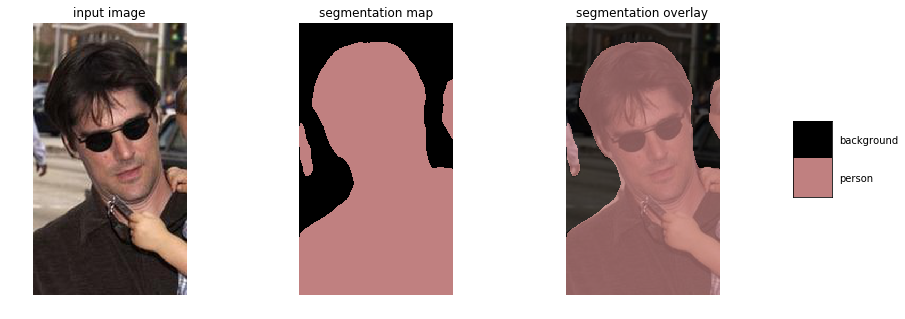

Mustache


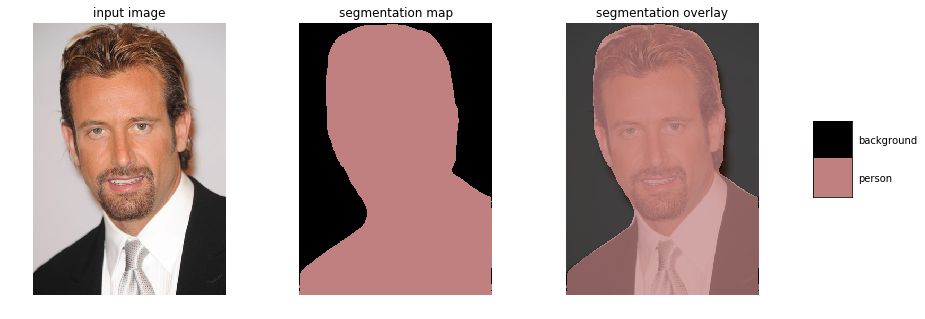

Blurry


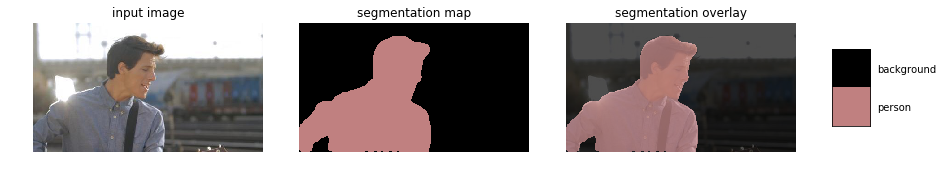

Wearing_Hat


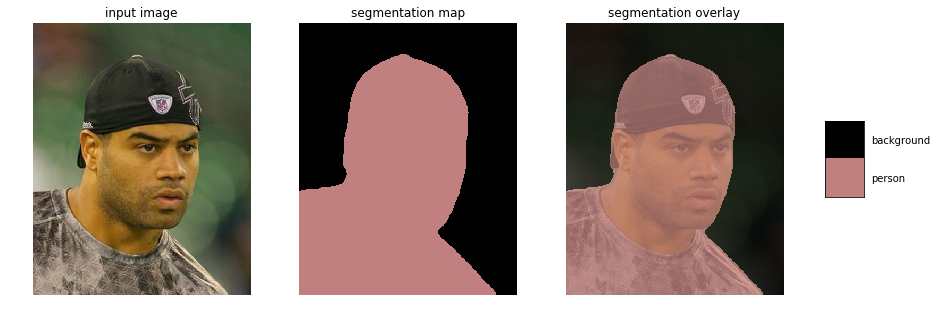

In [ ]:
def img_chooser(attribute):
    """Returns 1st image name with a particular attribute"""
    img_name = (celeb_attr[attribute] == 1).idxmax()
    return img_name

attr_list = ['Eyeglasses', 'Mustache', 'Blurry', 'Wearing_Hat']

for attr in attr_list: 
    img_title = img_chooser(attr)
    print(attr)
    img_to_vis(img_title)

Overall, the model performs well, but there are a few problem areas. When looking at the first image (attribute: glasses), there are 2 adults and a child partially in frame. All 3 are picked up and given the same treatment. This isn't so much a model error as it is a result of using a semantic segmentation model rather than an instance segmentation model. A model based on something such as Facebook's mask R-CNN would be a better choice if the desired application needed to identify different isntances of the same class within the image.

There are also some clear weaknesses when looking at fine details, mainly small strands of hair. Whether this is acceptable would depend on the implementation being used. Fine tuning with images that are higher resolution and limited to only faces would certainly give some gains in terms of fine detail resolution. For something such as auto-cropping, even finer resolution would be needed. One such solution is detailed by Shen et al. in their 2016 paper [2] explaining their implementation of Portrait FCN+. In order to get better resolution than standard matting solutions at the time, they incorporated spatial and shape data of facial structure locations into the model. Utilizing one of the many robust facial feature detectors available allows you to feed extra data channels such as facial centerpoint and normalized distance from center into your model. One improvement area utilized for Portrait FCN+ was to also compare images the mean mask from the training dataset. This feature alone improved their mean IoU from 94.61% to 95.91%, but does require that you crop and center your images before training. 

References  

[1]Takikawa, Towaki and Acuna, David and Jampani, Varun and Fidler, Sanja. Gated-SCNN: Gated Shape CNNs for Semantic Segmentation. In ICCV 2019.  


[2]Xiaoyong Shen, Aaron Hertzmann, Jiaya Jia, Sylvain Paris, Brian Price, Eli Shechtman, and Ian Sachs. 2016. Automatic portrait segmentation for image stylization. In Proceedings of the 37th Annual Conference of the European Association for Computer Graphics (EG ’16). Eurographics Association, Goslar, DEU, 93–102.